# Progressive Loading and Visualization

This notebook shows the simplest code to download all the New York Yellow Taxi trips from 2015. They were all geolocated and the trip data is stored in multiple CSV files.
We visualize progressively the pickup locations (where people have been picked up by the taxis).

First, we define a few constants, where the file is located, the desired resolution, and the url of the taxi file.

In [1]:
import warnings
warnings.filterwarnings("ignore")
LARGE_TAXI_FILE = "https://www.aviz.fr/nyc-taxi/yellow_tripdata_2015-01.csv.bz2"
RESOLUTION=512

In [2]:
# See https://en.wikipedia.org/wiki/Module:Location_map/data/USA_New_York_City
from dataclasses import dataclass
@dataclass
class Bounds:
    top: float = 40.92
    bottom: float = 40.49
    left: float = -74.27
    right: float = -73.68

bounds = Bounds()

In [3]:
from progressivis import (
    CSVLoader, Histogram2D, ConstDict, Heatmap, PDict,
    BinningIndexND, RangeQuery2d, Variable
)
import progressivis.core.aio as aio

col_x = "pickup_longitude"
col_y = "pickup_latitude"
bnds_min = PDict({col_x: bounds.left, col_y: bounds.bottom})
bnds_max = PDict({col_x: bounds.right, col_y: bounds.top})
# Create a csv loader for the taxi data file
csv = CSVLoader(LARGE_TAXI_FILE, index_col=False, usecols=[col_x, col_y])
# Create an indexing module on the csv loader output columns
index = BinningIndexND()
# Creates one index per numeric column
index.input.table = csv.output.result[col_x, col_y]
# Create a querying module
query = RangeQuery2d(column_x=col_x,
                     column_y=col_y
                    )
# Variable modules allow to dynamically modify their values; here, the query ranges
var_min = Variable(name="var_min")
var_max = Variable(name="var_max")
query.input.lower = var_min.output.result
query.input.upper = var_max.output.result
query.input.index = index.output.result
query.input.min = index.output.min_out
query.input.max = index.output.max_out
# Create a module to compute the 2D histogram of the two columns specified
# with the given resolution
histogram2d = Histogram2D(col_x, col_y, xbins=RESOLUTION, ybins=RESOLUTION)
# Connect the module to the csv results and the min,max bounds to rescale
histogram2d.input.table = query.output.result
histogram2d.input.min = query.output.min
histogram2d.input.max = query.output.max
# Create a module to create an heatmap image from the histogram2d
heatmap = Heatmap()
# Connect it to the histogram2d
heatmap.input.array = histogram2d.output.result

# Scheduler added module(s): ['binning_index_nd_1', 'csv_loader_1', 'heatmap_1', 'histogram2_d_1', 'range_query2d_1', 'var_max', 'var_min']


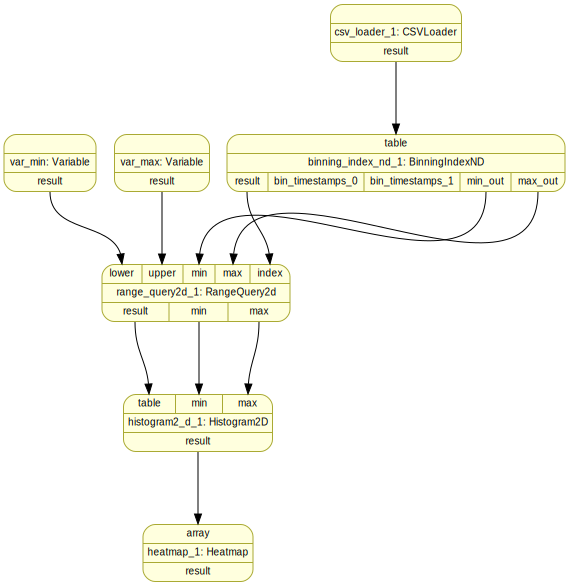

In [4]:
# Show the dataflow, you need to install graphviz to run this cell
# pip install graphviz
#
try:
    import graphviz
    src = csv.scheduler().to_graphviz()
    gvz=graphviz.Source(src)
    display(gvz)
except ImportError:
    pass

In [5]:
heatmap.display_notebook()
# Start the scheduler
csv.scheduler().task_start();
await aio.sleep(1)
await var_min.from_input(bnds_min)
await var_max.from_input(bnds_max);

Starting scheduler


In [6]:
import ipywidgets as widgets
long_slider = widgets.FloatRangeSlider(
    value=[bnds_min[col_x], bnds_max[col_x]],
    min=bnds_min[col_x],
    max=bnds_max[col_x],
    step=(bnds_max[col_x]-bnds_min[col_x])/10,
    description='Longitude:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
lat_slider = widgets.FloatRangeSlider(
    value=[bnds_min[col_y], bnds_max[col_y]],
    min=bnds_min[col_y],
    max=bnds_max[col_y],
    step=(bnds_max[col_y]-bnds_min[col_y])/10,
    description='Latitude:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
def observer(_):
    async def _coro():
        long_min, long_max = long_slider.value
        lat_min, lat_max = lat_slider.value
        await var_min.from_input({col_x: long_min, col_y: lat_min})
        await var_max.from_input({col_x: long_max, col_y: lat_max})
    aio.create_task(_coro())
long_slider.observe(observer, "value")
lat_slider.observe(observer, "value")
widgets.VBox([long_slider, lat_slider])

In [7]:
# Show what runs
csv.scheduler()

Id,Class,State,Last Update,Order
csv_loader_1,csv_loader,state_ready,2624,0
binning_index_nd_1,binning_index_nd,state_ready,2625,1
var_max,variable,state_blocked,2626,2
var_min,variable,state_blocked,2620,3
range_query2d_1,range_query2d,state_blocked,2621,4
histogram2_d_1,histogram2_d,state_blocked,2622,5
heatmap_1,heatmap,state_blocked,2623,6


In [8]:
# csv.scheduler().task_stop()